# Dimensionality Reduction and Embedding Analysis

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.cm as cmx
import seaborn as sns

import sklearn
from sklearn.metrics.pairwise import euclidean_distances, pairwise_distances
from sklearn.decomposition import PCA
from sklearn.manifold import trustworthiness
from sklearn.metrics import adjusted_mutual_info_score

from scipy.spatial import distance
from scipy.cluster import hierarchy
from scipy import stats

from umap import UMAP

from utils import compute_trustworthiness_by_lidtype
from plotting import plot_barplot_trust_by_lidtype, generate_col_colors

## 1) Data Files

In [2]:
data_root = Path("../data")

In [3]:
one_hot_embedding_path = data_root / "one_hot_msa_175_orgs.csv"
esm_650M_layer_33_path = data_root / "adk_esm_650M_layer33_embeddings.csv"
msa_kcat_path = data_root / "adk_msa_temp.csv"
adk_dataset_path = data_root / "adk_ortholog_dataset_km_filtered.csv"

In [4]:
# read in msa_temp_df
full_msa_df = pd.read_csv(msa_kcat_path, index_col=0)
# drop msa columns
full_msa_df = full_msa_df.drop(columns=[str(i) for i in range(499)])
# read in adk_dataset
dataset = pd.read_csv(adk_dataset_path)

In [5]:
# join with activity data
full_msa_df = dataset[["org_name", "kcat_mean", "Km_mean"]].merge(full_msa_df, how="right", on="org_name") 

In [6]:
esm_df = pd.read_csv(esm_650M_layer_33_path)

## 2) Run PCA and UMAP
___

In [7]:
if sklearn.__version__ != "1.3.0":
    print(f"Warning: sklearn-1.3.0 was used in this study. You are using sklearn-{sklearn.__version__}.")
    print("There are slight variations in PCA calulcations in different versions, so visualizations may differ.")
else:
    pass

In [8]:
# compute PCA on ESM embeddings
pca = PCA(n_components=2)
esm_pca = pca.fit_transform(esm_df.iloc[:, 1:])
esm_pca_df = pd.DataFrame(esm_pca, columns=["PC1", "PC2"])
esm_pca_df["org_name"] = esm_df["org_name"]

In [9]:
esm_joined_pca_df = full_msa_df.copy().merge(esm_pca_df, how="right", on="org_name")

In [10]:
# run UMAP on ESM embeddings
umap = UMAP(n_components=2, random_state=314)
esm_umap = umap.fit_transform(esm_df.iloc[:, 1:])
esm_umap_df = pd.DataFrame(esm_umap, columns=["UMAP1", "UMAP2"])
esm_umap_df["org_name"] = esm_df["org_name"]

esm_joined_umap_df = full_msa_df.copy().merge(esm_umap_df, how="right", on="org_name")

/Users/duncanmuir/code/adk_evolutionary_landscape/.venv/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [11]:
# Remove outlier orgs from MSA that we don't have ESM embeddings for, nor study in the paper (~10)
esm_joined_pca_df = esm_joined_pca_df.dropna(subset=["org_in_library"])
esm_joined_umap_df = esm_joined_umap_df.dropna(subset=["org_in_library"])

# 3) Visualize UMAP
___
NOTE: there is some random seed varibility between operating systems, so the plots may show some variability from the paper figures.

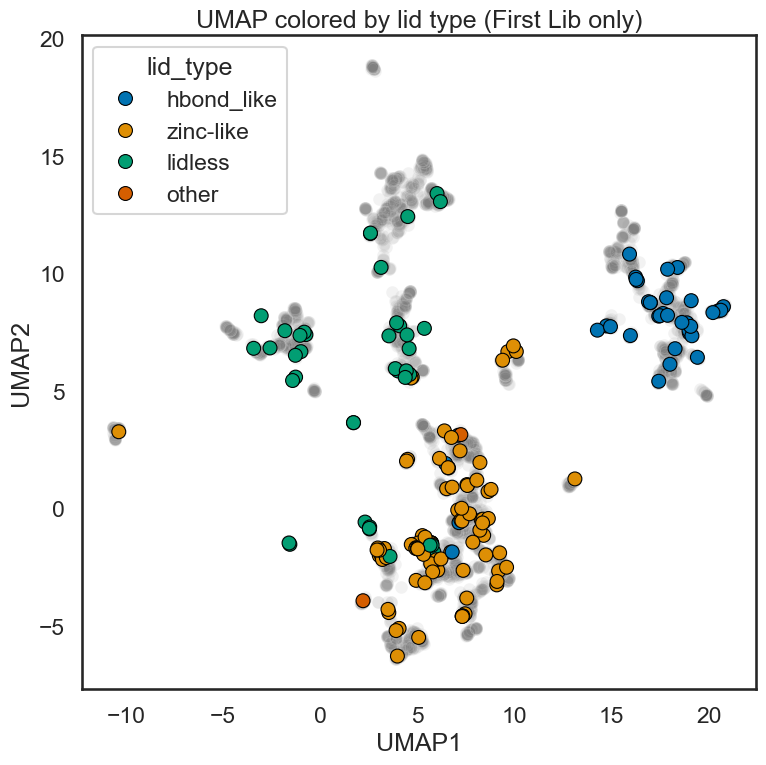

In [12]:
# same as above but grey out the non-first lib sequences
sns.set_context("talk")
sns.set_style("white")
sns.set_palette("colorblind")
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=esm_joined_umap_df, x="UMAP1", y="UMAP2", color="grey", ax=ax, alpha=0.1)
sns.scatterplot(data=esm_joined_umap_df[~esm_joined_umap_df["kcat_mean"].isna()], x="UMAP1", y="UMAP2", hue="lid_type", ax=ax, s=100, edgecolor="black")
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
ax.set_title("UMAP colored by lid type (First Lib only)")
plt.tight_layout()
plt.show()

In [13]:
# set up kcat color map
kcat_cmap = matplotlib.colormaps["viridis"]
esm_joined_umap_df["log10_kcat"] = np.log10(esm_joined_umap_df["kcat_mean"])
kcat_normalize = plt.Normalize(vmin=0, vmax=3)
kcat_colors = [kcat_cmap(kcat_normalize(value)) for value in esm_joined_umap_df[~esm_joined_umap_df["log10_kcat"].isna()]["log10_kcat"]]

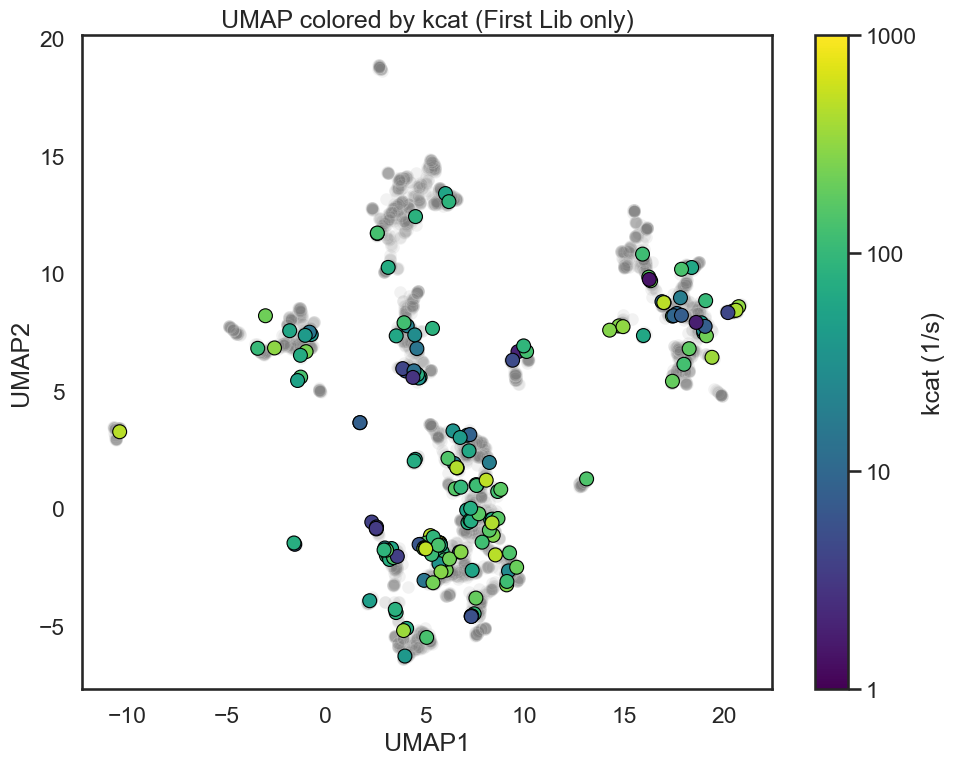

In [14]:
sns.set_context("talk")
sns.set_style("white")
sns.set_palette("colorblind")

fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=esm_joined_umap_df, x="UMAP1", y="UMAP2", color="grey", ax=ax, alpha=0.1)
sns.scatterplot(data=esm_joined_umap_df[~esm_joined_umap_df["log10_kcat"].isna()], x="UMAP1", y="UMAP2",
 ax=ax, s=100, edgecolor="black",
color=kcat_colors,    
legend=False)
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
ax.set_title("UMAP colored by kcat (First Lib only)")
# add colorbar
sm = plt.cm.ScalarMappable(cmap=kcat_cmap, norm=kcat_normalize)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, label="kcat (1/s)")
cbar.set_ticks([0,1, 2, 3])
ticks = cbar.get_ticks()
ticks = 10**ticks
cbar.set_ticklabels(ticks)
plt.tight_layout()
plt.show()


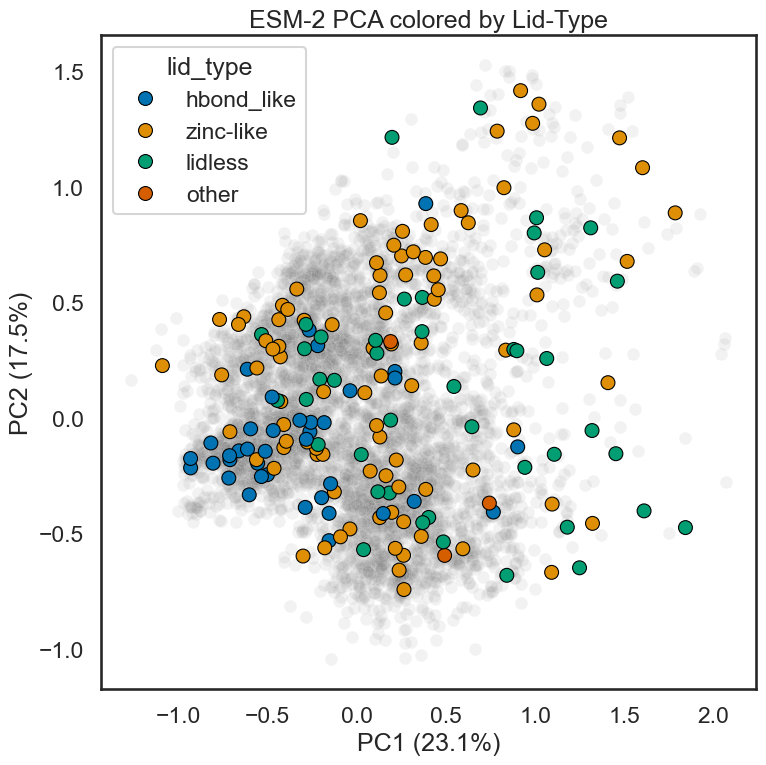

In [15]:
sns.set_context("talk")
sns.set_style("white")
sns.set_palette("colorblind")
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=esm_joined_pca_df, x="PC1", y="PC2", color="grey", ax=ax, alpha=0.1)
sns.scatterplot(data=esm_joined_pca_df[~esm_joined_pca_df["kcat_mean"].isna()], x="PC1", y="PC2", hue="lid_type", ax=ax, s=100, edgecolor="black")
# label axes with percent explained variance
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
ax.set_title("ESM-2 PCA colored by Lid-Type")
plt.tight_layout()
plt.show()

In [16]:
esm_joined_pca_df["log10_kcat"] = np.log10(esm_joined_pca_df["kcat_mean"])

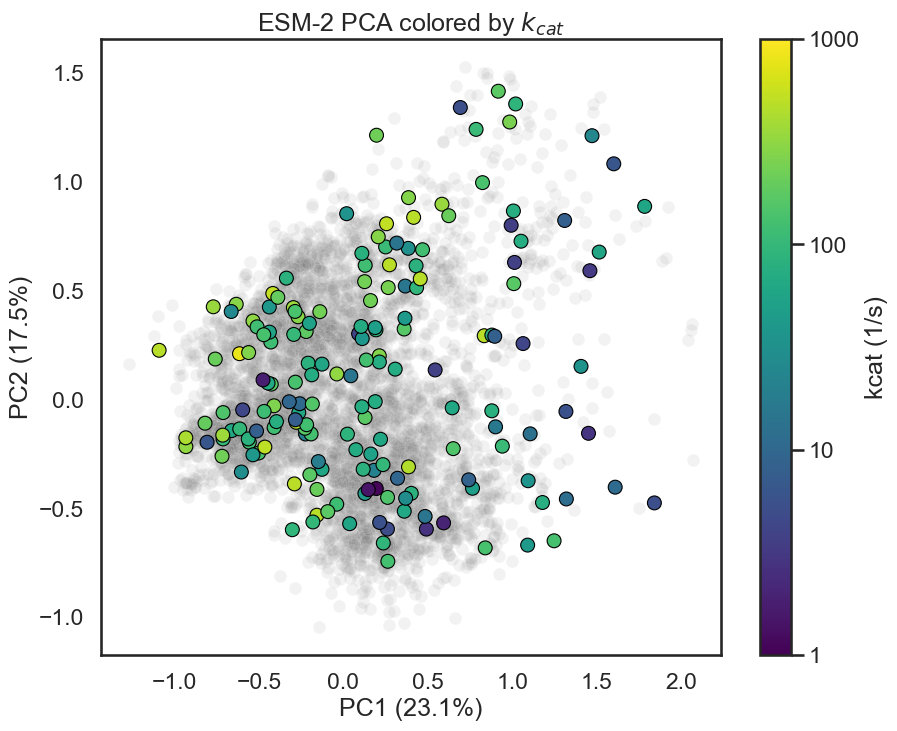

In [18]:
sns.set_context("talk")
sns.set_style("white")
sns.set_palette("colorblind")

fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=esm_joined_pca_df, x="PC1", y="PC2", color="grey", ax=ax, alpha=0.1)
sns.scatterplot(data=esm_joined_pca_df[~esm_joined_pca_df["log10_kcat"].isna()], x="PC1", y="PC2",
 ax=ax, s=100, edgecolor="black",
color=kcat_colors,
legend=False)
# label axes with percent explained variance
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
ax.set_title("ESM-2 PCA colored by $k_{cat}$")
# add colorbar
cbar = fig.colorbar(sm, ax=ax, label="kcat (1/s)")
cbar.set_ticks([0,1, 2, 3])
ticks = cbar.get_ticks()
ticks = 10**ticks
cbar.set_ticklabels(ticks)
plt.show()
    

# Trustworthiness
___

In [19]:
esm_kcat_df = pd.merge(esm_df, full_msa_df[["org_name", "kcat_mean", "Km_mean", "temperature", "lid_type"]], on="org_name").dropna()
esm_kcat_df["kcat/km"] = esm_kcat_df["kcat_mean"] / (esm_kcat_df["Km_mean"] * 1e-6)

In [21]:
one_hot_df = pd.read_csv(one_hot_embedding_path)
one_hot_kcat_df = pd.merge(one_hot_df, full_msa_df[["org_name", "kcat_mean", "Km_mean", "lid_type"]], on="org_name").dropna()
one_hot_kcat_df["kcat/km"] = one_hot_kcat_df["kcat_mean"] / (one_hot_kcat_df["Km_mean"] * 1e-6)

### Trustworthiness Across a Range of k


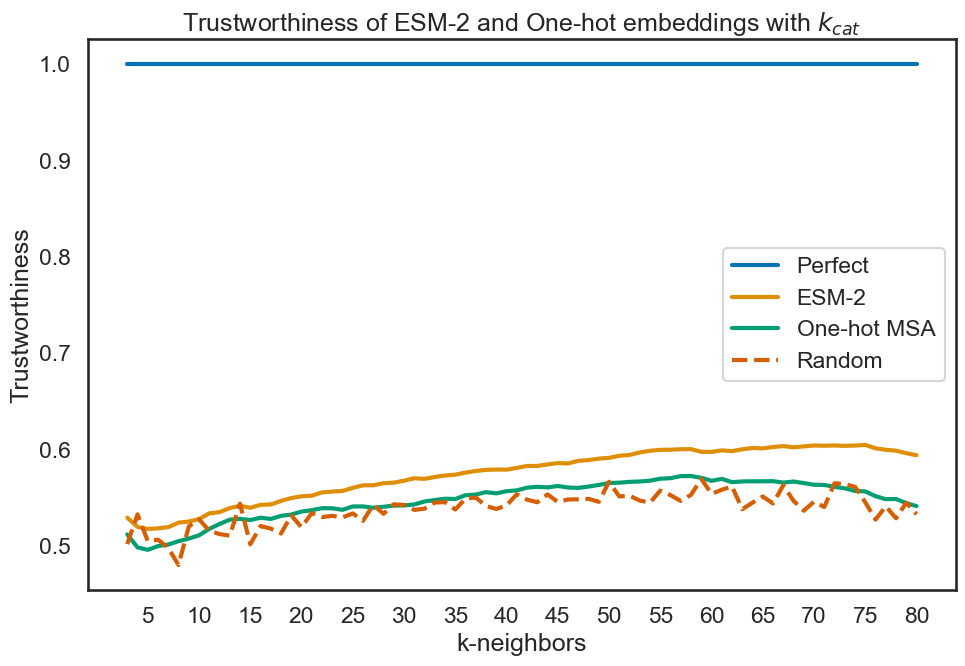

In [22]:
kcats = one_hot_kcat_df["kcat_mean"]
TOP_N = 80
np.random.seed(314)
kcat_trust = []

kcat_shuffled_trust = []
esm_kcat_trust = []
esm_temp_trust = []
one_hot_kcat_trust = []
for k in range(3, TOP_N+1):
    esm_kcat_trust.append(trustworthiness(esm_kcat_df.iloc[:, 1:-5], 
                                          esm_kcat_df["kcat_mean"].to_numpy().reshape(-1,1), 
                                          n_neighbors=k))
    kcat_trust.append(trustworthiness(esm_kcat_df["kcat_mean"].to_numpy().reshape(-1,1), 
                                      esm_kcat_df["kcat_mean"].to_numpy().reshape(-1,1), 
                                      n_neighbors=k))
    kcat_shuffled_trust.append(trustworthiness(esm_kcat_df["kcat_mean"].to_numpy().reshape(-1,1), 
                                               np.random.permutation(esm_kcat_df["kcat_mean"].to_numpy()).reshape(-1,1), 
                                               n_neighbors=k))
    one_hot_kcat_trust.append(trustworthiness(one_hot_kcat_df.iloc[:, :-5], 
                                              one_hot_kcat_df["kcat_mean"].to_numpy().reshape(-1,1), 
                                              n_neighbors=k, 
                                              metric="hamming"))


# plot trustworthiness
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(range(3, TOP_N + 1), kcat_trust, label="Perfect", linewidth=3)


ax.plot(range(3, TOP_N + 1), esm_kcat_trust, label="ESM-2", linewidth=3)
ax.plot(range(3, TOP_N + 1), one_hot_kcat_trust, label="One-hot MSA", linewidth=3)
ax.plot(range(3, TOP_N + 1), kcat_shuffled_trust, label="Random", linewidth=3, linestyle="--")


ax.set_xlabel("k-neighbors")
ax.set_ylabel("Trustworthiness")
ax.set_title("Trustworthiness of ESM-2 and One-hot embeddings with $k_{cat}$")
# set xtickst so 5, 10, 15, 20 are labeled
ax.set_xticks(range(5, TOP_N+1, 5))

ax.legend()
plt.tight_layout()
plt.show()

## Lid-type Trustworthiness ESM

In [23]:
kcat_esm_trust_dict = compute_trustworthiness_by_lidtype(df=esm_kcat_df, 
                                   lid_types=["hbond_like", "zinc-like", "lidless"], 
                                   col_name="kcat_mean", 
                                   embedding_start_idx=1,
                                   embedding_end_idx=-5,
                                   top_n_neighbors=15)

In [24]:
km_esm_trust_dict = compute_trustworthiness_by_lidtype(df=esm_kcat_df,
                                      lid_types=["hbond_like", "zinc-like", "lidless"], 
                                      col_name="Km_mean", 
                                      embedding_start_idx=1,
                                      embedding_end_idx=-5,
                                      top_n_neighbors=15)

In [25]:
kcat_km_esm_trust_dict = compute_trustworthiness_by_lidtype(df=esm_kcat_df,
                                        lid_types=["hbond_like", "zinc-like", "lidless"], 
                                        col_name="kcat/km", 
                                        embedding_start_idx=1,
                                        embedding_end_idx=-5,
                                        top_n_neighbors=15)

## Lid-type Trustworthiness One-hot

In [26]:
kcat_one_hot_trust_dict = compute_trustworthiness_by_lidtype(df=one_hot_kcat_df,
                                      lid_types=["hbond_like", "zinc-like", "lidless"], 
                                      col_name="kcat_mean", 
                                      embedding_start_idx=0,
                                      embedding_end_idx=-5,
                                      top_n_neighbors=15,
                                      metric="hamming",
                                      random_shuffle_n=30)


In [27]:
km_one_hot_trust_dict = compute_trustworthiness_by_lidtype(df=one_hot_kcat_df,
                                        lid_types=["hbond_like", "zinc-like", "lidless"], 
                                        col_name="Km_mean", 
                                        embedding_start_idx=0,
                                        embedding_end_idx=-5,
                                        top_n_neighbors=15,
                                        metric="hamming",
                                        random_shuffle_n=30)

In [28]:
kcat_km_one_hot_trust_dict = compute_trustworthiness_by_lidtype(df=one_hot_kcat_df,
                                        lid_types=["hbond_like", "zinc-like", "lidless"], 
                                        col_name="kcat/km", 
                                        embedding_start_idx=0,
                                        embedding_end_idx=-5,
                                        top_n_neighbors=15,
                                        metric="hamming",
                                        random_shuffle_n=30)

0 Rectangle(xy=(-0.4, 0), width=0.4, height=0.51779, angle=0)
1 Rectangle(xy=(0.6, 0), width=0.4, height=0.589635, angle=0)
2 Rectangle(xy=(1.6, 0), width=0.4, height=0.587018, angle=0)
3 Rectangle(xy=(2.6, 0), width=0.4, height=0.51373, angle=0)
4 Rectangle(xy=(5.55112e-17, 0), width=0.4, height=0.496109, angle=0)
5 Rectangle(xy=(1, 0), width=0.4, height=0.537143, angle=0)
6 Rectangle(xy=(2, 0), width=0.4, height=0.544386, angle=0)
7 Rectangle(xy=(3, 0), width=0.4, height=0.508407, angle=0)
8 Rectangle(xy=(0, 0), width=0, height=0, angle=0)
9 Rectangle(xy=(0, 0), width=0, height=0, angle=0)


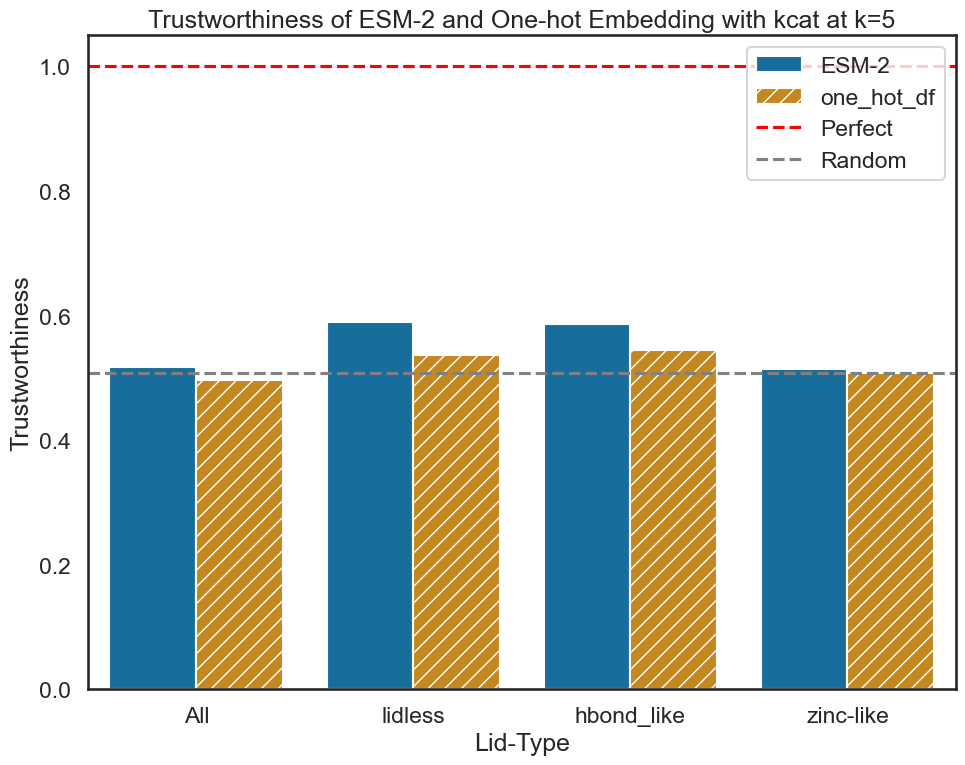

In [29]:
plot_barplot_trust_by_lidtype(method_trust_dict={ "ESM-2": kcat_esm_trust_dict,
                               "one_hot_df": kcat_one_hot_trust_dict},
                               lid_types=["lidless","hbond_like", "zinc-like"], 
                               k=5, 
                               title="Trustworthiness of ESM-2 and One-hot Embedding with kcat at k=5")

0 Rectangle(xy=(-0.4, 0), width=0.4, height=0.516003, angle=0)
1 Rectangle(xy=(0.6, 0), width=0.4, height=0.533422, angle=0)
2 Rectangle(xy=(1.6, 0), width=0.4, height=0.520526, angle=0)
3 Rectangle(xy=(2.6, 0), width=0.4, height=0.511585, angle=0)
4 Rectangle(xy=(5.55112e-17, 0), width=0.4, height=0.524346, angle=0)
5 Rectangle(xy=(1, 0), width=0.4, height=0.546047, angle=0)
6 Rectangle(xy=(2, 0), width=0.4, height=0.501228, angle=0)
7 Rectangle(xy=(3, 0), width=0.4, height=0.504621, angle=0)
8 Rectangle(xy=(0, 0), width=0, height=0, angle=0)
9 Rectangle(xy=(0, 0), width=0, height=0, angle=0)


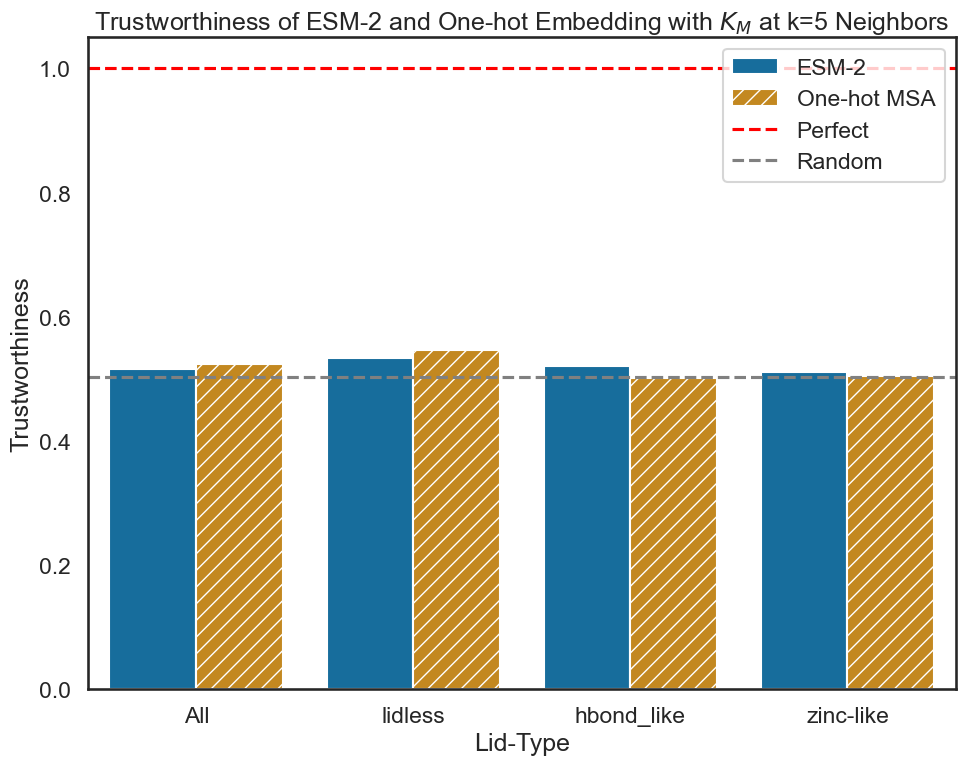

In [30]:
plot_barplot_trust_by_lidtype(method_trust_dict={ "ESM-2": km_esm_trust_dict,
                               "One-hot MSA": km_one_hot_trust_dict},
                               lid_types=["lidless","hbond_like", "zinc-like"], 
                               k=5, 
                               title="Trustworthiness of ESM-2 and One-hot Embedding with $K_M$ at k=5 Neighbors")

0 Rectangle(xy=(-0.4, 0), width=0.4, height=0.540756, angle=0)
1 Rectangle(xy=(0.6, 0), width=0.4, height=0.573289, angle=0)
2 Rectangle(xy=(1.6, 0), width=0.4, height=0.542982, angle=0)
3 Rectangle(xy=(2.6, 0), width=0.4, height=0.551489, angle=0)
4 Rectangle(xy=(5.55112e-17, 0), width=0.4, height=0.52334, angle=0)
5 Rectangle(xy=(1, 0), width=0.4, height=0.548704, angle=0)
6 Rectangle(xy=(2, 0), width=0.4, height=0.53, angle=0)
7 Rectangle(xy=(3, 0), width=0.4, height=0.52824, angle=0)
8 Rectangle(xy=(0, 0), width=0, height=0, angle=0)
9 Rectangle(xy=(0, 0), width=0, height=0, angle=0)


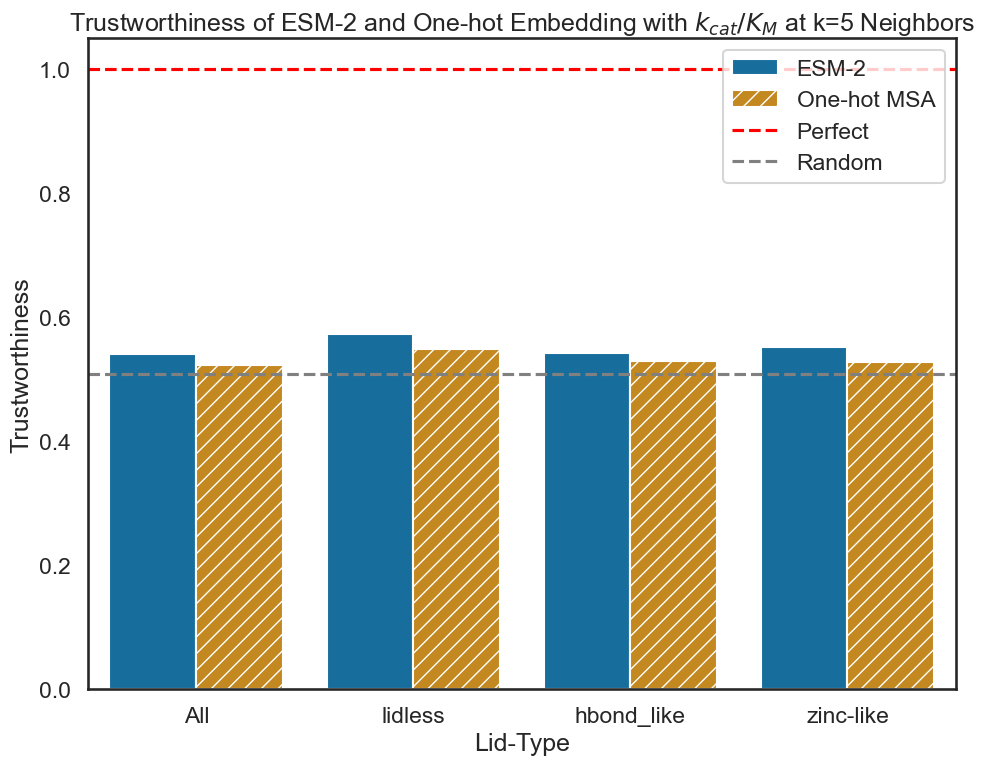

In [31]:
plot_barplot_trust_by_lidtype(method_trust_dict = {"ESM-2": kcat_km_esm_trust_dict,
                               "One-hot MSA": kcat_km_one_hot_trust_dict},
                              lid_types=["lidless","hbond_like", "zinc-like"], 
                              k=5, 
                              title="Trustworthiness of ESM-2 and One-hot Embedding with $k_{cat}/K_M$ at k=5 Neighbors")

# Hierarchical Clustering
___

In [32]:
esm_first_lib_array = esm_kcat_df.iloc[:, 1:1281].to_numpy()
assert esm_first_lib_array.shape == (175, 1280)

In [33]:
esm_first_lib_euclidean_array = euclidean_distances(esm_first_lib_array, esm_first_lib_array)

In [34]:
esm_row_linkage = hierarchy.linkage(
    distance.pdist(esm_first_lib_euclidean_array), method='average')

esm_col_linkage = hierarchy.linkage(
    distance.pdist(esm_first_lib_euclidean_array.T), method='average')

In [35]:
esm_col_colors, esm_col_color_dict = generate_col_colors(list(esm_kcat_df['lid_type']))
esm_handles = [Patch(facecolor=esm_col_color_dict[name]) for name in esm_col_color_dict]


In [36]:
# colormap kcat with viridis
kcat_cmap = matplotlib.colormaps["viridis"]
kcat_normalize = plt.Normalize(vmin=0, 
                               vmax=3)
esm_kcat_colors = [kcat_cmap(kcat_normalize(np.log10(value))) for value in esm_kcat_df["kcat_mean"]]

Text(0.5, 1.0, 'ESM-2: Euclidean Distance Clustermap')

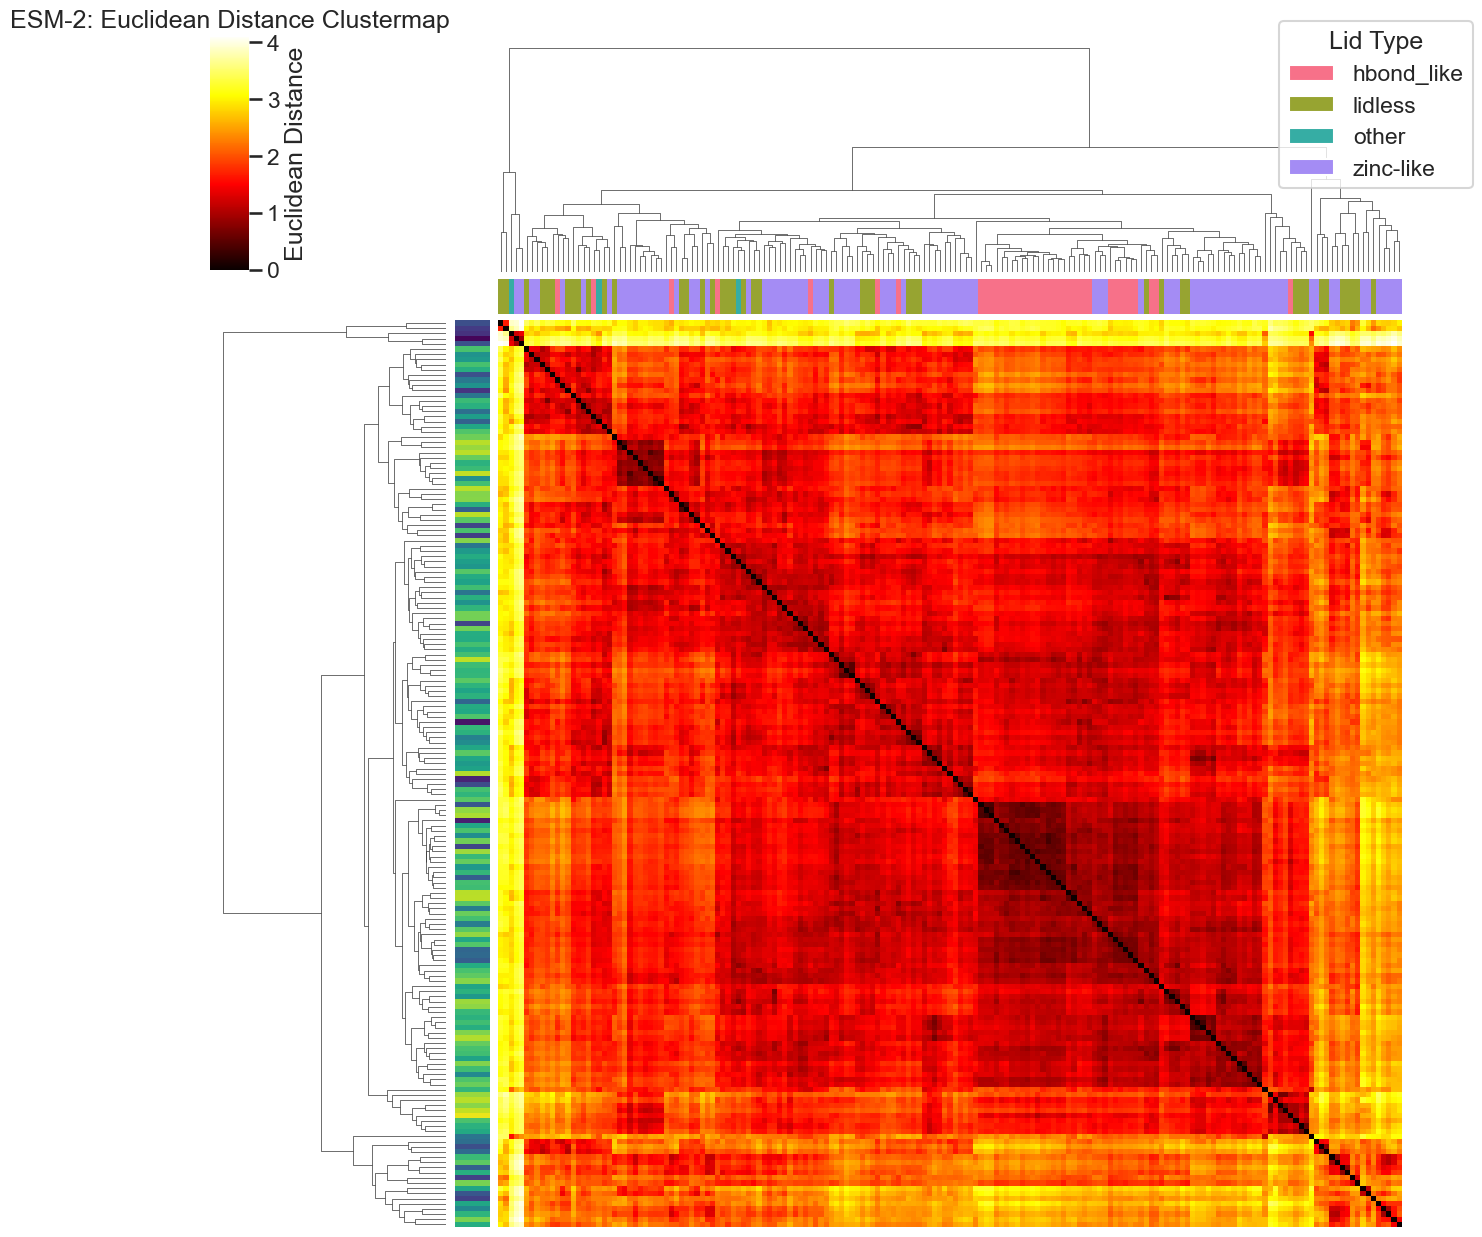

In [37]:
cg = sns.clustermap(
    esm_first_lib_euclidean_array,
    row_linkage=esm_row_linkage, col_linkage=esm_col_linkage,
    col_colors=esm_col_colors,
    row_colors=esm_kcat_colors,
    method="average", figsize=(13, 13),
    cmap="hot", cbar_pos=(0.02, 0.8, 0.03, 0.18), cbar_kws={"label": "Euclidean Distance"},
     )

# remove tick labels
cg.ax_heatmap.set_xticklabels([])
cg.ax_heatmap.set_yticklabels([])
# remove y ticks
cg.ax_heatmap.set_yticks([])
plt.legend(esm_handles, esm_col_color_dict, title='Lid Type',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')


plt.title("ESM-2: Euclidean Distance Clustermap")


# hamming distance clustermap


In [38]:
hamming_arr = pairwise_distances(one_hot_kcat_df.to_numpy()[:,:-5], metric='hamming', n_jobs=4)

In [39]:
hamming_row_linkage = hierarchy.linkage(
    distance.pdist(hamming_arr), method='average')

hamming_col_linkage = hierarchy.linkage(
    distance.pdist(hamming_arr.T), method='average')

In [40]:
hamming_col_colors, hamming_col_color_dict = generate_col_colors(list(one_hot_kcat_df['lid_type']))
hamming_handles = [Patch(facecolor=hamming_col_color_dict[name]) for name in hamming_col_color_dict]


In [41]:
hamming_kcat_colors = [kcat_cmap(kcat_normalize(np.log10(value))) for value in one_hot_kcat_df["kcat_mean"]]

Text(0.5, 1.0, 'One-hot MSA: Hamming Distance Clustermap')

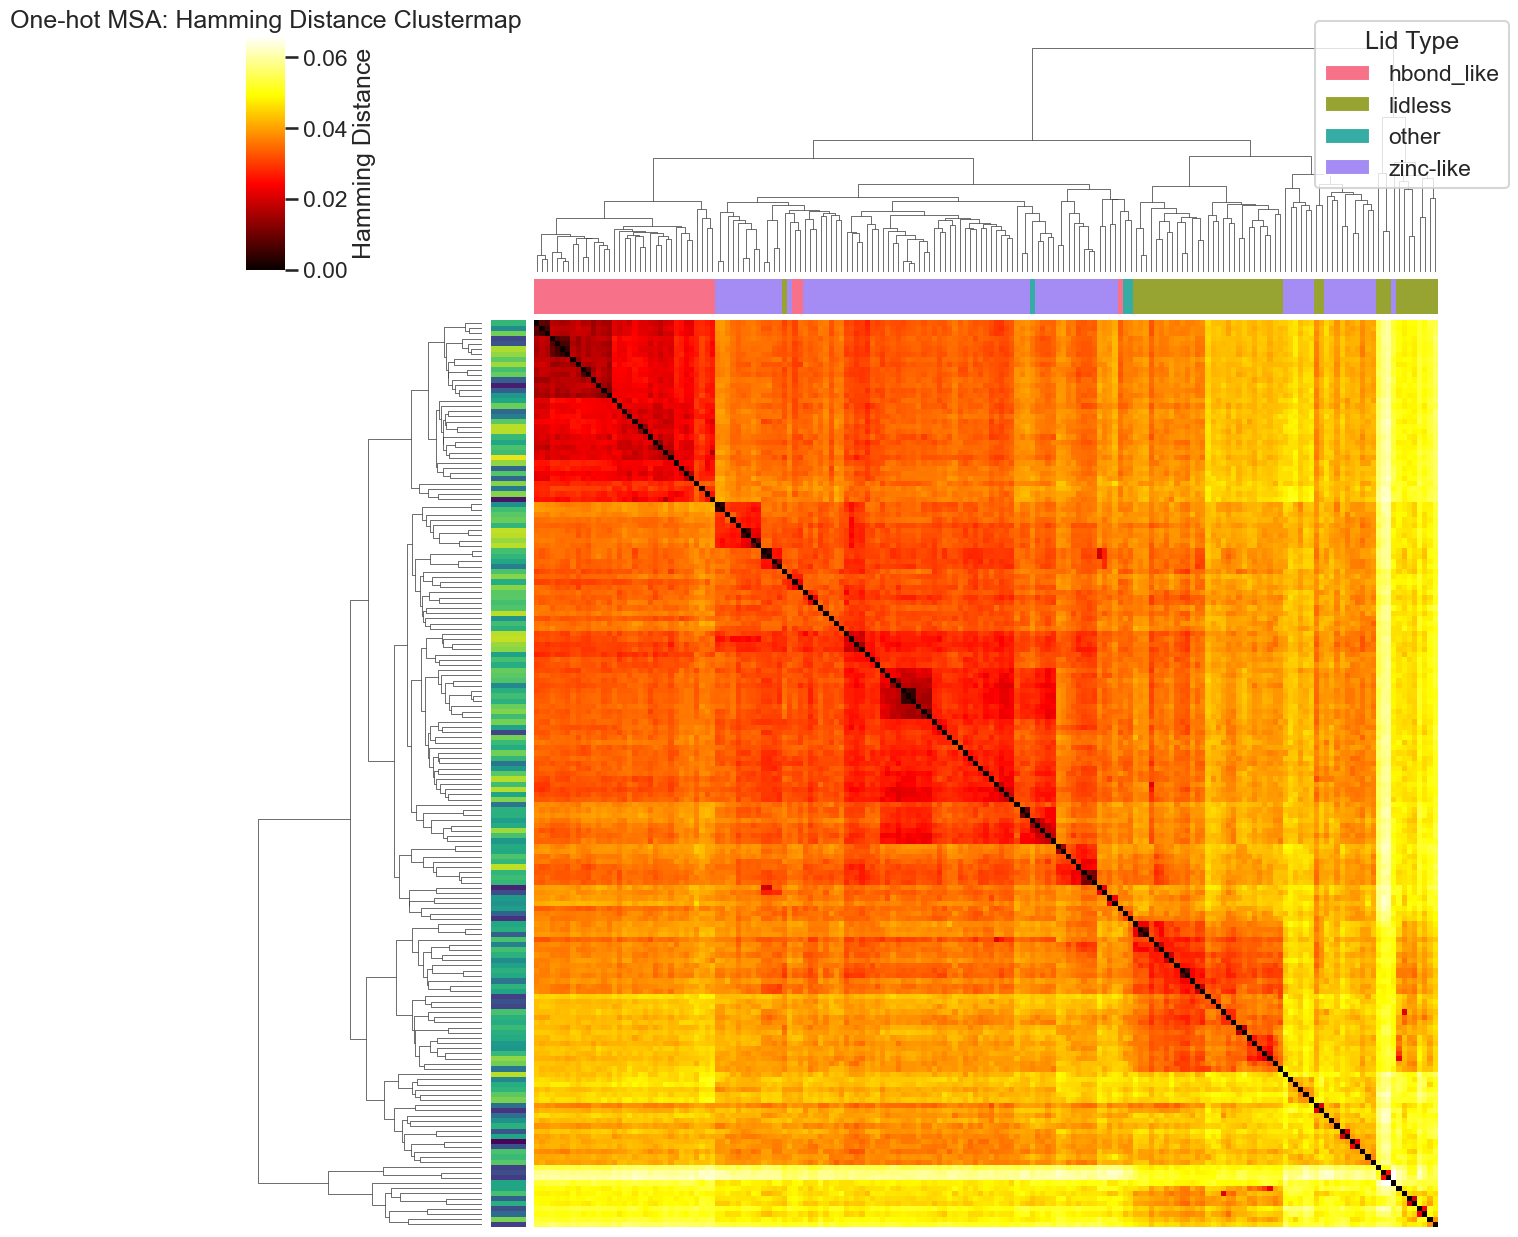

In [42]:
cg = sns.clustermap(
    hamming_arr,
    row_linkage=hamming_row_linkage, col_linkage=hamming_col_linkage,
    col_colors=hamming_col_colors,
    row_colors=hamming_kcat_colors,
     method="average", figsize=(13, 13),
     cmap="hot", cbar_pos=(0.02, 0.8, 0.03, 0.18), cbar_kws={"label": "Hamming Distance"})

# remove tick labels
cg.ax_heatmap.set_xticklabels([])
cg.ax_heatmap.set_yticklabels([])
# remove y ticks
cg.ax_heatmap.set_yticks([])

plt.legend(hamming_handles, hamming_col_color_dict, title='Lid Type',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')
plt.title("One-hot MSA: Hamming Distance Clustermap")

In [43]:
esm_clusters = hierarchy.fcluster(esm_row_linkage, t=30, criterion='maxclust')

In [44]:
hamming_clusters = hierarchy.fcluster(hamming_row_linkage, t=30, criterion='maxclust')

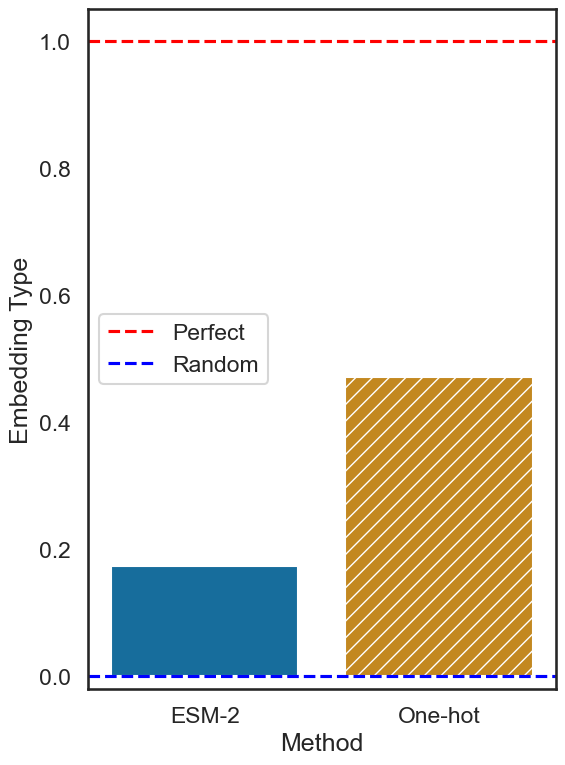

In [45]:
np.random.seed(314)
fig, ax = plt.subplots(figsize=(6, 8))
ami_df = pd.DataFrame({"Method": ["ESM-2","One-hot"],
"AMI": [
        adjusted_mutual_info_score(esm_clusters, esm_kcat_df["lid_type"]),
        adjusted_mutual_info_score(hamming_clusters, one_hot_kcat_df["lid_type"]),
        ]})
sns.barplot(data=ami_df, x="Method", y="AMI", hue="Method", ax=ax, palette="colorblind")


ax.patches[-1].set_hatch("//")

ax.set_xlabel("Method")
ax.set_ylabel("Embedding Type")
ax.set_ylim(bottom=-.02, top=1.05)
ax.axhline(y=adjusted_mutual_info_score(hamming_clusters, hamming_clusters), color='r', linestyle='--', label="Perfect")
#ax.axhline(y=adjusted_mutual_info_score(hamming_clusters, np.random.permutation(one_hot_kcat_df["lid_type"])), color='b', linestyle='--', label="Random")
ax.axhline(y=0, color='b', linestyle='--', label="Random")

ax.legend()
plt.rcParams['pdf.fonttype'] = 42
plt.tight_layout()
#plt.savefig("../data/fig_pdfs/hierarchical_clustering_ami_new.pdf")

## Supplemental PC1 Correlations
___

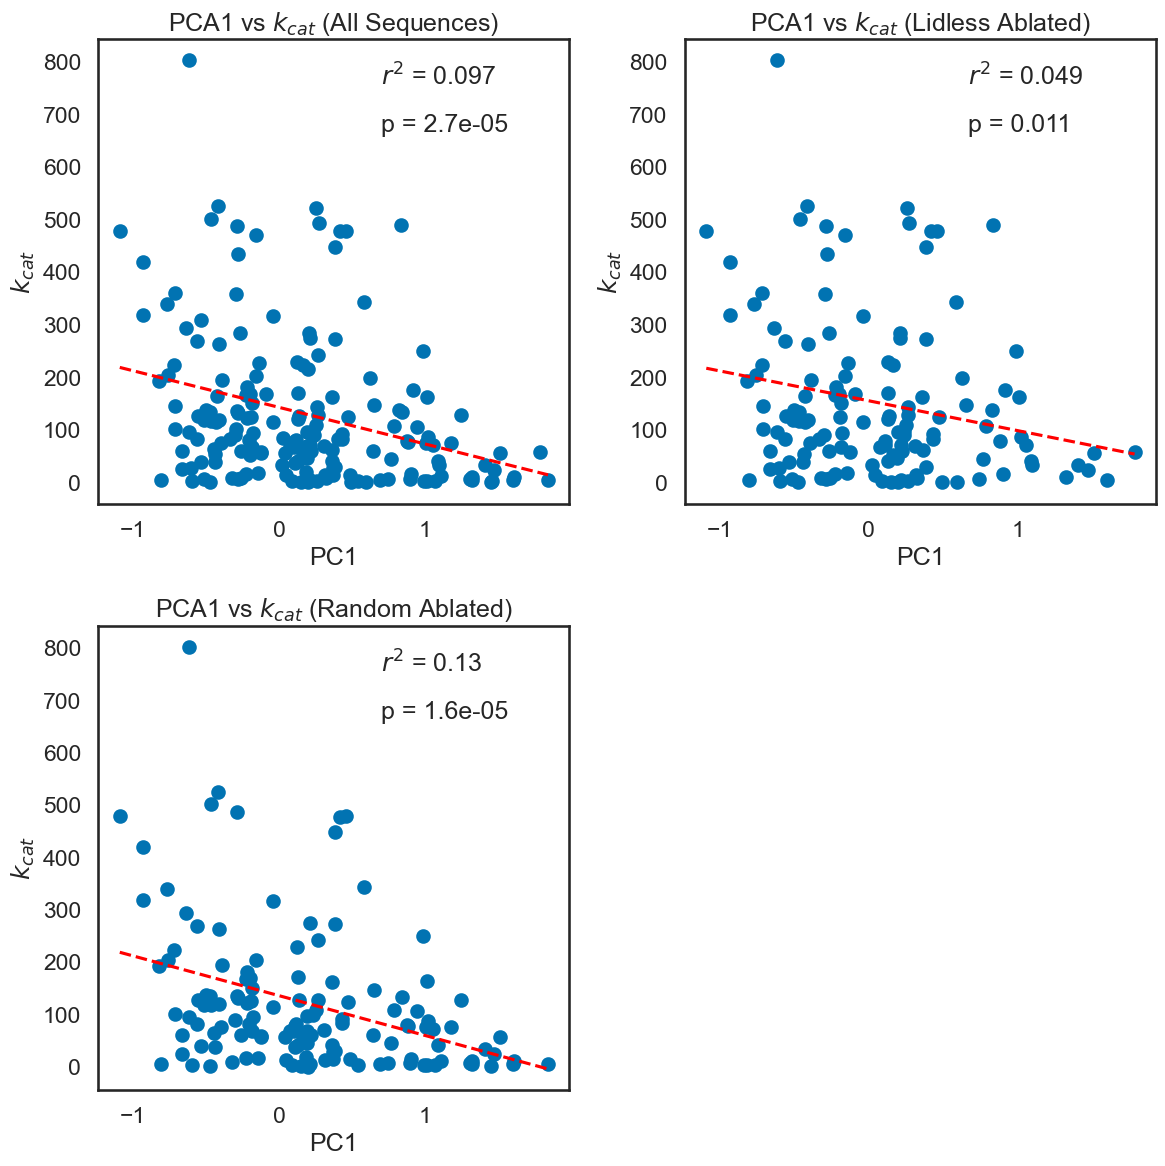

In [46]:
np.random.seed(314)
# PC1 linear regressions
fig, ax = plt.subplots(2,2,figsize=(12,12))
ax = ax.flatten()
# all sequences
x = esm_joined_pca_df[~esm_joined_pca_df["kcat_mean"].isna()]["PC1"]
y = esm_joined_pca_df[~esm_joined_pca_df["kcat_mean"].isna()]["kcat_mean"]
ax[0].scatter(x, y)
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
x_lin = np.linspace(min(x), max(x), 100)

ax[0].plot(x_lin, slope*x_lin + intercept, color="red", linestyle="--")
ax[0].set_xlabel("PC1")
ax[0].set_ylabel("$k_{cat}$")
ax[0].text(0.6, 0.9, f"$r^2$ = {r_value**2:.2}", transform=ax[0].transAxes)
ax[0].text(0.6, 0.8, f"p = {p_value:.2}", transform=ax[0].transAxes)
ax[0].set_title("PCA1 vs $k_{cat}$ (All Sequences)")

# lidless
x = esm_joined_pca_df[~esm_joined_pca_df["kcat_mean"].isna() & (esm_joined_pca_df["lid_type"] != "lidless")]["PC1"]
y = esm_joined_pca_df[~esm_joined_pca_df["kcat_mean"].isna() & (esm_joined_pca_df["lid_type"] != "lidless")]["kcat_mean"]
ax[1].scatter(x, y)
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
x_lin = np.linspace(min(x), max(x), 100)

ax[1].plot(x_lin, slope*x_lin + intercept, color="red", linestyle="--")
ax[1].set_xlabel("PC1")
ax[1].set_ylabel("$k_{cat}$")
ax[1].text(0.6, 0.9, f"$r^2$ = {r_value**2:.2}", transform=ax[1].transAxes)
ax[1].text(0.6, 0.8, f"p = {p_value:.2}", transform=ax[1].transAxes)
ax[1].set_title("PCA1 vs $k_{cat}$ (Lidless Ablated)")

# random subset ablated of equal size to lidless
# random subset of equal size to lidless
lidless_subset = esm_joined_pca_df[~esm_joined_pca_df["kcat_mean"].isna() & (esm_joined_pca_df["lid_type"] == "lidless")]
ablated_subset = esm_joined_pca_df[~esm_joined_pca_df["kcat_mean"].isna()].sample(n=len(esm_joined_pca_df[~esm_joined_pca_df["kcat_mean"].isna()]) - len(lidless_subset))

x = ablated_subset["PC1"]
y = ablated_subset["kcat_mean"]
ax[2].scatter(x, y)
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
x_lin = np.linspace(min(x), max(x), 100)

ax[2].plot(x_lin, slope*x_lin + intercept, color="red", linestyle="--")
ax[2].set_xlabel("PC1")
ax[2].set_ylabel("$k_{cat}$")
ax[2].text(0.6, 0.9, f"$r^2$ = {r_value**2:.2}", transform=ax[2].transAxes)
ax[2].text(0.6, 0.8, f"p = {p_value:.2}", transform=ax[2].transAxes)
ax[2].set_title("PCA1 vs $k_{cat}$ (Random Ablated)")

# delete the last subplot
fig.delaxes(ax[3])

plt.tight_layout()
plt.show()
